In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import acquire as aq
import prepare as pr
import explore as ex
import wrangle as wr
import math


from itertools import combinations
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings('ignore')

---

# Planning : 
- Objectives: 
    - [x] Document code, processes, findings, and key takeaways
    - [ ] Create Modules that make the code easier to read and replicable
    - [ ] Ask exploratory questions
    - [ ] Construct a model to predict assessed home value for single family properties using regression techniques
    - [ ] Make recommendations
    - [ ] Refine the work to fit a report of 5 minutes 
    - [ ] Understand the data well enough to answer any questions about codes, methods and takeaways.  

---

## Aquisition and Preparing the data

In [2]:
df = aq.get_zillow_data()

In [3]:
df.head()

,bathroomcnt,bedroomcnt,taxvaluedollarcnt,taxamount,fips,calculatedfinishedsquarefeet,yearbuilt
0,3.5,4.0,1023282.0,11013.72,6059.0,3100.0,1998.0
1,1.0,2.0,464000.0,5672.48,6111.0,1465.0,1967.0
2,2.0,3.0,564778.0,6488.30,6059.0,1243.0,1962.0
3,3.0,4.0,145143.0,1777.51,6037.0,2376.0,1970.0
4,3.0,4.0,773303.0,9516.26,6037.0,2962.0,1950.0


In [4]:
# view the size of the dataframe
df.shape

(52441, 7)

***Initial dataframe size == 52441 as outlined in the project***

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52441 non-null  float64
 1   bedroomcnt                    52441 non-null  float64
 2   taxvaluedollarcnt             52440 non-null  float64
 3   taxamount                     52437 non-null  float64
 4   fips                          52441 non-null  float64
 5   calculatedfinishedsquarefeet  52359 non-null  float64
 6   yearbuilt                     52325 non-null  float64
dtypes: float64(7)
memory usage: 2.8 MB


In [6]:
df.bedroomcnt.min(), df.bathroomcnt.min(), df.calculatedfinishedsquarefeet.max()

(0.0, 0.0, 21929.0)

### Takeaways :
- A single family home should have at least 1 bathroom and 1 bedroom, as well as not be 21k feet.
- I will identify these as outliers, and remove them from the dataframe so that the integrity of the data isn't comprimised, and charts/model and display better accuracy.

### Visualizing nulls and outliers :

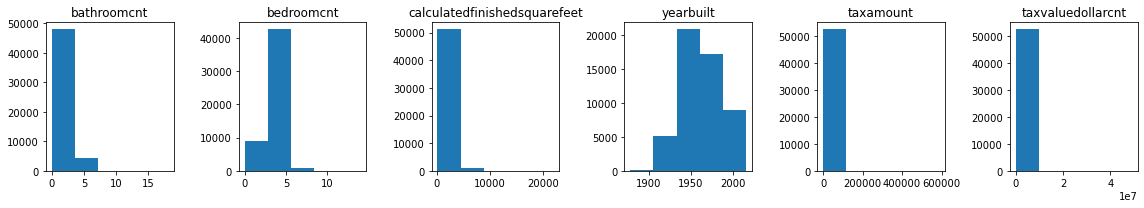

In [7]:
plt.figure(figsize=(16,3))

# list of columns 
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 
        'yearbuilt', 'taxamount', 'taxvaluedollarcnt']

for i, col in enumerate(cols):
    
    # i starts at 0 but plot sums should start at 1
    plot_number = i + 1
    
    # create subplot
    plt.subplot(1,6, plot_number)
    
    #title with each col name
    plt.title(col)
    
    # display hist for each column
    df[col].hist(bins=5)
    
    # hide gridlines
    plt.grid(False)
    plt.tight_layout()

- There are excess points on the charts that mis-skews them. Ex. Tax amount is one bar, as the next point is a tax amount of 200,000.

### Drop nulls and remove outliers :

In [8]:
# Nulls located in many of the columns. Im the prepare.py prep function, 
# those are dropped while maintaining integrity of the dataset

# outliers were also dropped to increase accuracy of the dataframe.

zillow = pr.prep_zillow_initial(df)

In [9]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44581 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   44581 non-null  float64
 1   bedrooms    44581 non-null  float64
 2   tax_value   44581 non-null  float64
 3   tax_amount  44581 non-null  float64
 4   fips        44581 non-null  object 
 5   sqft        44581 non-null  float64
 6   year_built  44581 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.7+ MB


In [10]:
zillow.bedrooms = zillow.bedrooms.astype(int)
zillow.tax_value = zillow.tax_value.astype(int)
zillow.sqft = zillow.sqft.astype(int)
zillow.year_built = zillow.year_built.astype(int)

In [11]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44581 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   44581 non-null  float64
 1   bedrooms    44581 non-null  int64  
 2   tax_value   44581 non-null  int64  
 3   tax_amount  44581 non-null  float64
 4   fips        44581 non-null  object 
 5   sqft        44581 non-null  int64  
 6   year_built  44581 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 2.7+ MB


### Sample and Summarize

In [12]:
zillow.head()

,bathrooms,bedrooms,tax_value,tax_amount,fips,sqft,year_built
0,3.5,4,1023282,11013.72,Orange County,3100,1998
1,1.0,2,464000,5672.48,Ventura County,1465,1967
2,2.0,3,564778,6488.30,Orange County,1243,1962
3,3.0,4,145143,1777.51,Los Angeles,2376,1970
4,3.0,4,773303,9516.26,Los Angeles,2962,1950


# Data Dictionary : 
>|Column | Description | Dtype|
|--------- | --------- | ----------- |
|bathrooms| number of bathrooms| float64|
|bedrooms| number of bedrooms| int64|
|tax_value| final home estimated price| int64|
|tax_amount| amount of taxes| float64|
|fips| county location| String|
|sqft| home sqare feet| int64|
|year_built| home year was built| int64|

## Understanding Fips:
- Fips is the county code associated with each state. 

### 06 = California
- 037 = Los Angeles
- 059 = Orange County 
- 111 = Ventura County

[Click here for the full list of all State and County codes](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)

In [13]:
# shape of dataframe after outliers and nulls were removed
zillow.shape

(44581, 7)

In [14]:
# reading summary statistics for numeric columns
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,44581.0,2.100974,0.721314,1.00,2.0,2.00,2.50,4.0
bedrooms,44581.0,3.209798,0.786990,2.00,3.0,3.00,4.00,5.0
tax_value,44581.0,364679.267513,233433.465607,1000.00,172147.0,332872.00,513526.00,1038547.0
tax_amount,44581.0,4530.664946,2663.772457,49.18,2423.6,4197.91,6185.98,12915.8
sqft,44581.0,1695.829367,604.836904,152.00,1240.0,1570.00,2052.00,3566.0
year_built,44581.0,1962.484220,21.108653,1910.00,1950.0,1960.00,1977.00,2016.0


In [15]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44581 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   44581 non-null  float64
 1   bedrooms    44581 non-null  int64  
 2   tax_value   44581 non-null  int64  
 3   tax_amount  44581 non-null  float64
 4   fips        44581 non-null  object 
 5   sqft        44581 non-null  int64  
 6   year_built  44581 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 2.7+ MB


### Acquire and Summarize Takeaways:
- Null values have been dropped, removing about 8k homes from the dataset
- As fips represents the county/state that the homes are located, the distinct numerical values (3) were changed to categorical columns that visually represent their counties.
- Column naming conventions were changed for more readable and recognizable content
- Bedroms and bathroom outliers were changed where bedrooms or bathrooms would equal 0, as these are not representitive of a family home as outlined : [CHAPTER 96. - SINGLE- AND MULTI-FAMILY HOUSING CODE, of the Code of Ordinances](https://library.municode.com/tx/carrollton/codes/code_of_ordinances?nodeId=TITIXHESAPRMA_CH96SIULMIHOCO)

---

## Visualizing Distributions of data
- Samples are required to visualize datapoints as the entire dataset is too large to fit into a proper graphic.

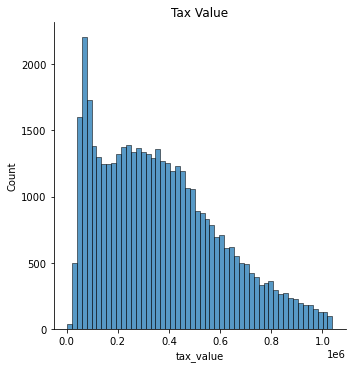

In [16]:
# displot of the target variable
sns.displot(x='tax_value', data=zillow)
plt.title('Tax Value')
plt.show()

### Takeaways:
- Distribution of the target variable is positively skewed.

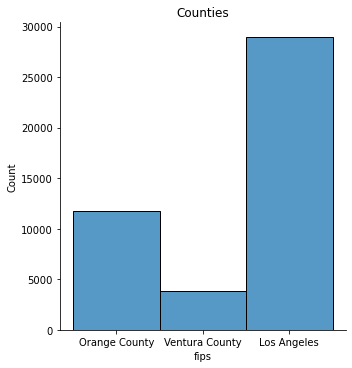

In [17]:
# displot of the target variable
sns.displot(x='fips', data=zillow)
plt.title('Counties')
plt.show()

In [18]:
zillow.fips.value_counts()

Los Angeles       28967
Orange County     11797
Ventura County     3817
Name: fips, dtype: int64

### Takeaways : 
- Los angeles has the largest distribution in the dataset.

##### Now plotting each numeric column of interest and showing the distribution on a separate subplot.


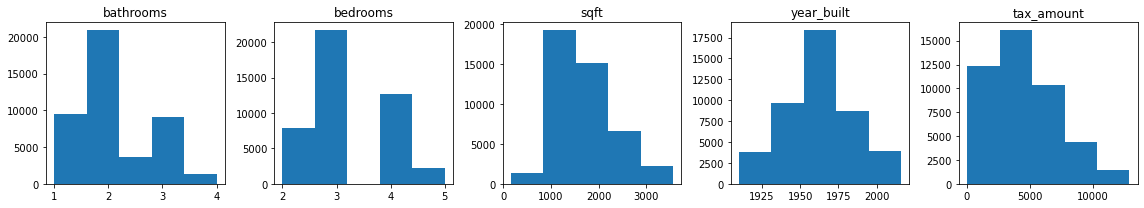

In [19]:
plt.figure(figsize=(16,3))

# list of columns 
cols = ['bathrooms', 'bedrooms', 'sqft', 'year_built', 'tax_amount']

for i, col in enumerate(cols):
    
    # i starts at 0 but plot sums should start at 1
    plot_number = i + 1
    
    # create subplot
    plt.subplot(1,5, plot_number)
    
    #title with each col name
    plt.title(col)
    
    # display hist for each column
    zillow[col].hist(bins=5)
    
    # hide gridlines
    plt.grid(False)
    plt.tight_layout()

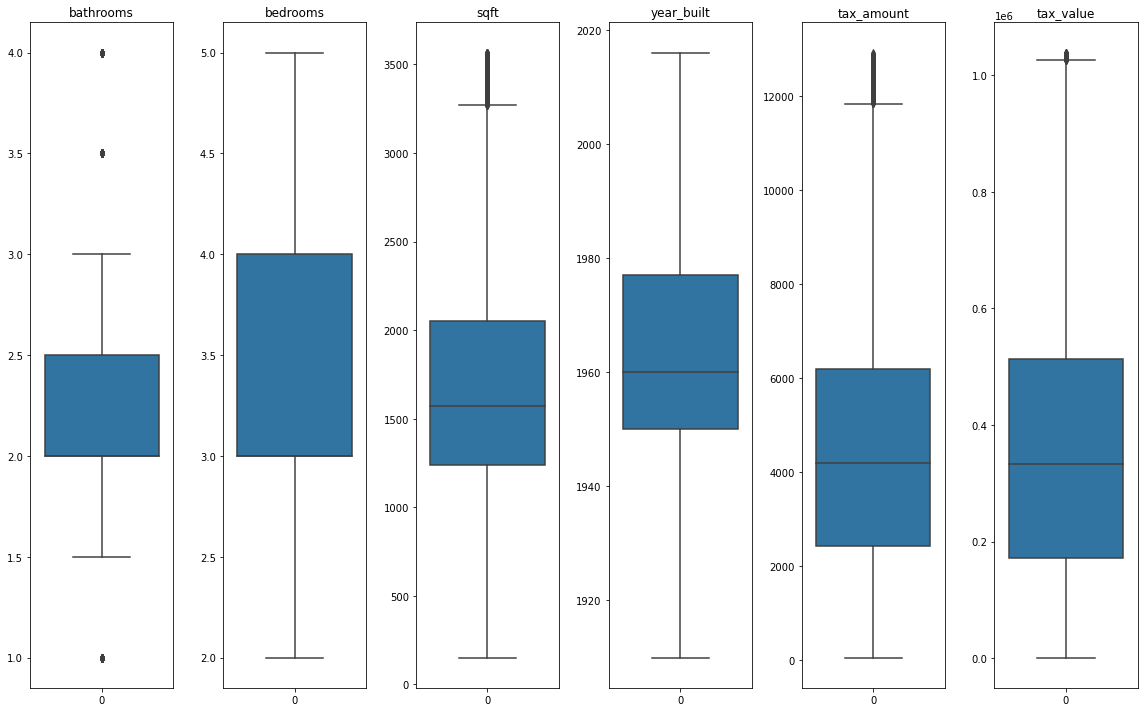

In [20]:
plt.figure(figsize=(16,10))

# list of columns 
cols = ['bathrooms', 'bedrooms', 'sqft', 'year_built', 'tax_amount', 'tax_value']

for i, col in enumerate(cols):
    
    # i starts at 0 but plot sums should start at 1
    plot_number = i + 1
    
    # create subplot
    plt.subplot(1,len(cols), plot_number)
    
    #title with each col name
    plt.title(col)
    
    # display hist for each column
    sns.boxplot(data=zillow[col])
    
    # hide gridlines
    plt.grid(False)
    plt.tight_layout()
plt.show()

### Takeaways:
- Most of the features are pretty normally distributed, except for bedrooms and bathrooms.
- Tax value and tax amount are almost identical. This is potential leak of information about the tax value, thus should be removed from this dataset.
- There are still some outliers, however, for better creditable accuracy they won't be removed. These can be considered special cases.

---


# Exploration of the data :
- to begin with exploring the data, I have to split the data.

### Splitting the data:

In [21]:
train, validate, test = pr.prep_zillow(df)

In [22]:
train.shape, validate.shape, test.shape

((24964, 6), (10700, 6), (8917, 6))

In [23]:
train.head()

,bathrooms,bedrooms,tax_value,fips,sqft,year_built
41302,3.0,4.0,538082.0,Los Angeles,2440.0,2000.0
17668,1.0,3.0,199530.0,Los Angeles,1180.0,1953.0
37475,3.0,4.0,73511.0,Los Angeles,1498.0,1955.0
46111,3.0,4.0,161276.0,Los Angeles,2310.0,2007.0
33211,1.0,2.0,64982.0,Los Angeles,1241.0,1951.0


In [24]:
# understanding the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24964 entries, 41302 to 11858
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   24964 non-null  float64
 1   bedrooms    24964 non-null  float64
 2   tax_value   24964 non-null  float64
 3   fips        24964 non-null  object 
 4   sqft        24964 non-null  float64
 5   year_built  24964 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


In [25]:
# describing the data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,24964.0,2.100344,0.721121,1.0,2.00,2.0,2.5,4.0
bedrooms,24964.0,3.209141,0.788266,2.0,3.00,3.0,4.0,5.0
tax_value,24964.0,364780.283208,234557.001783,9242.0,172429.75,331478.0,514070.0,1038547.0
sqft,24964.0,1697.171807,604.454758,326.0,1242.00,1570.0,2052.0,3566.0
year_built,24964.0,1962.643286,21.035603,1910.0,1950.00,1960.0,1977.0,2015.0


### Questions to Answer : 
- Are certain counties more expensive / have a higher average value than others? If so, are there any features that directly impact the difference in value?
- Why do some properties have a much higher value than others when they are located so close to each other? 
- Is there a relationship between the year a home was built and it's value? 
- Is there a feature that is the most impactful in assessing the value of a home? 

In [26]:
train_corr = train.drop(columns=['fips']).corr()

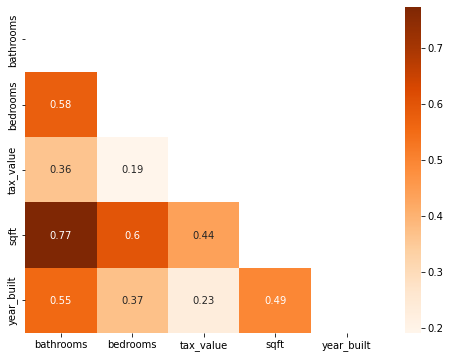

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='Oranges', annot=True,
            mask=np.triu(train_corr))
plt.show()

### Heatmap Takeaway : 
- sqaurefoot 'sqft' has the highest correlation with tax value amount (.42)
- The second strongest driver of tax value seems to be the number of bathrooms.


### A look at each attributed paired against one another : 

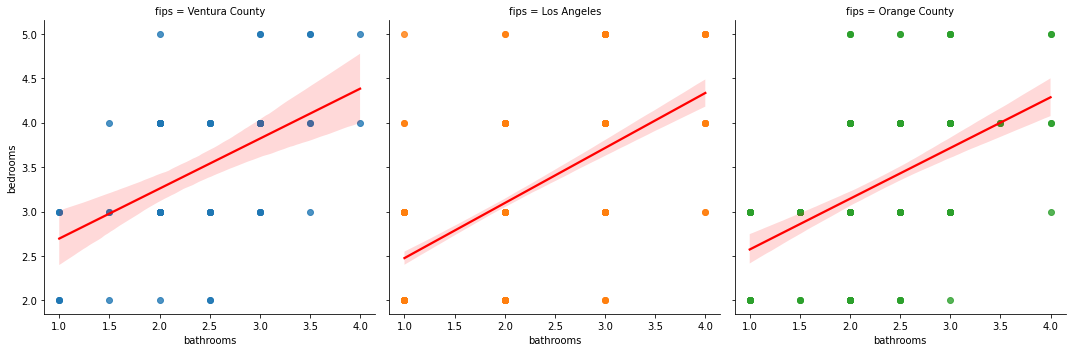

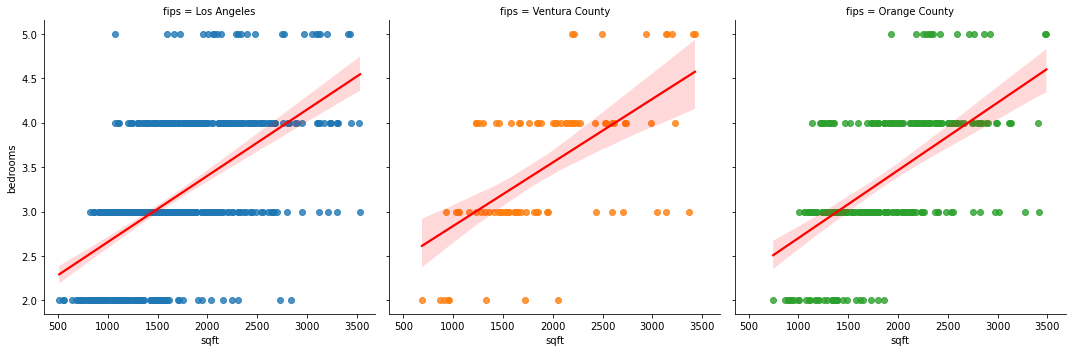

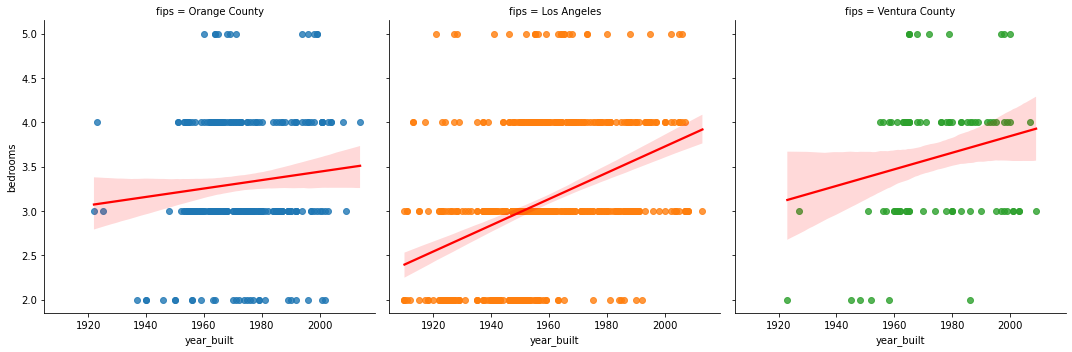

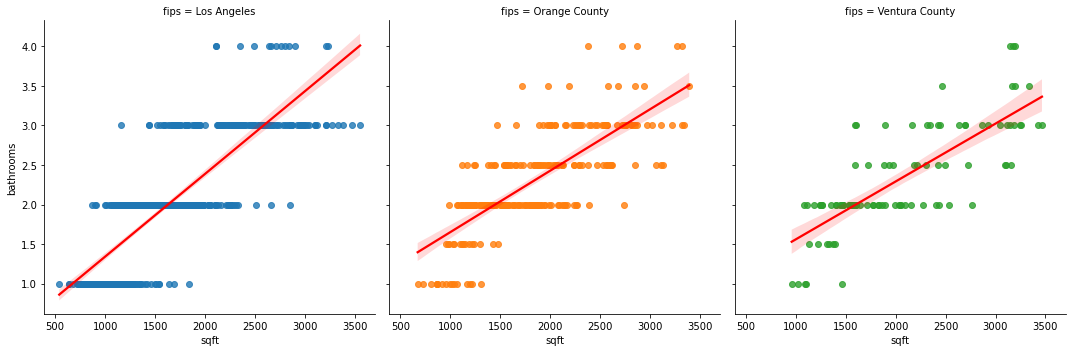

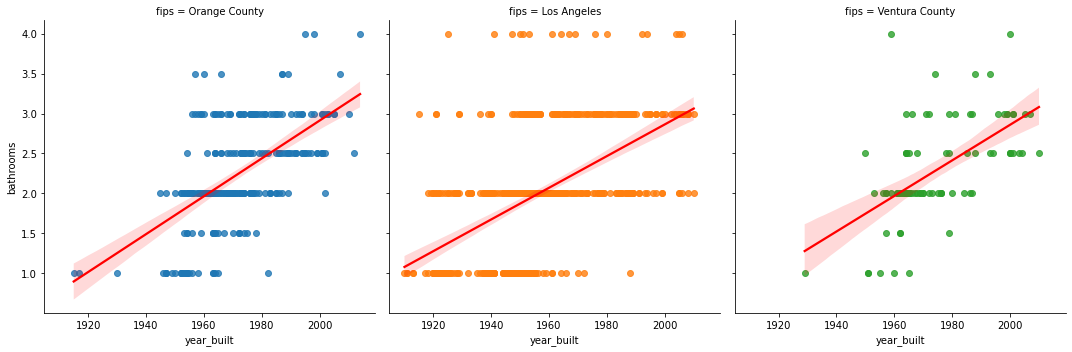

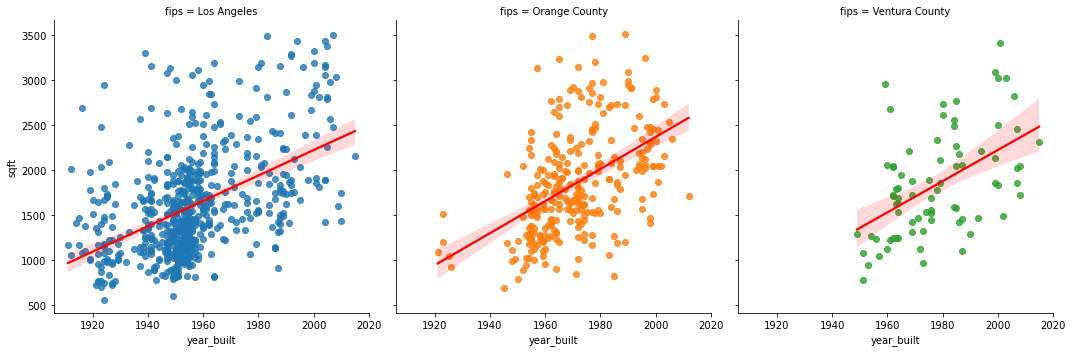

In [28]:
ex.plot_variable_pairs(train)

### Univariate Explortation via plot distribution :


<Figure size 720x936 with 0 Axes>

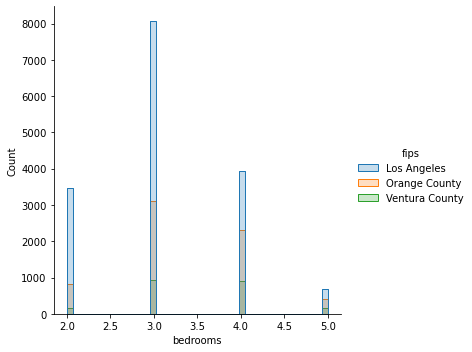

<Figure size 720x936 with 0 Axes>

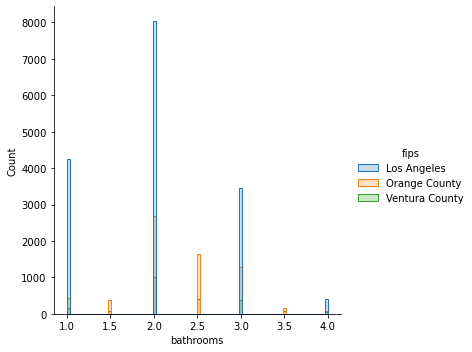

<Figure size 720x936 with 0 Axes>

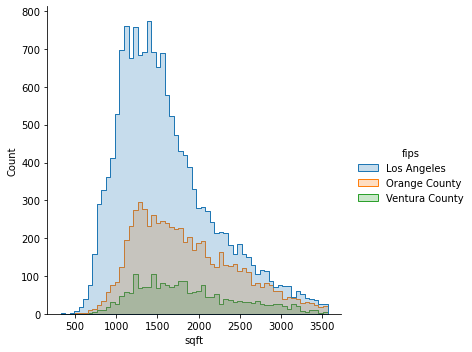

<Figure size 720x936 with 0 Axes>

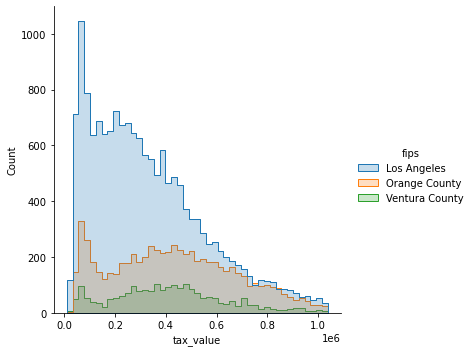

In [29]:
ex.plot_categorical_and_continuous_vars_displot(train)

### Takeaways : 
- LA having the largest distribution of data, has the most count of each feature.
- LA also has the most amount of home being built around the 1950s.

# Statistical Tests : 

### Reiterate - Questions to Answer : 
- Are certain counties more expensive / have a higher average value than others? If so, are there any features that directly impact the difference in value?
- Why do some properties have a much higher value than others when they are located so close to each other? 
- Is there a relationship between the year a home was built and it's value? 
- Is there a feature that is the most impactful in assessing the value of a home? 

### Question 1 : Are certain counties more expensive/ have a higher tax value on average than others?

<Figure size 864x576 with 0 Axes>

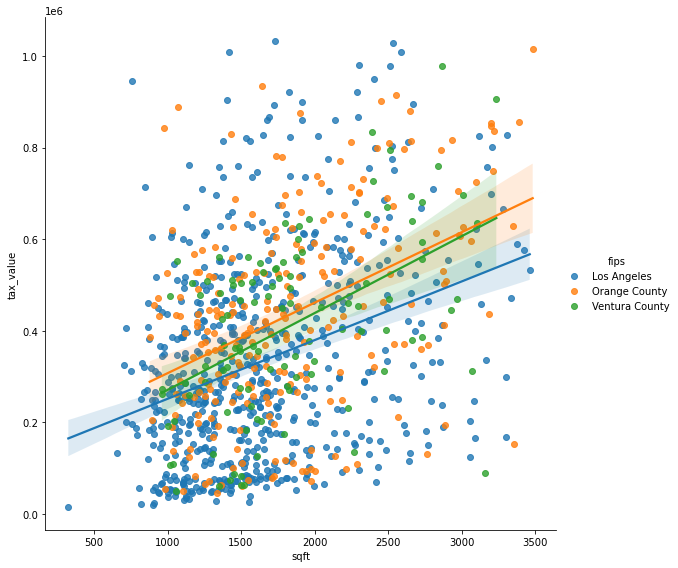

In [30]:
plt.figure(figsize=(12,8))
sns.lmplot(x='sqft', y='tax_value',
                data = train.sample(1000), hue = 'fips', size = 8)

### Takeaways : 
- Los Angeles has, on average, cheaper tax value  than Ventura county and Orange County.
- Ventura and Orange County are about the same in terms of average value.

### To further support let's look at a heatmap of each county

In [31]:
la_data = train[train.fips == 'Los Angeles']
orangecounty_data = train[train.fips == 'Orange County']
ventura_data = train[train.fips == 'Ventura County']

In [32]:
la_data.shape, orangecounty_data.shape, ventura_data.shape

((16155, 6), (6657, 6), (2152, 6))

In [33]:
la_corr = la_data.corr()
orangecounty_corr = orangecounty_data.corr()
ventura_corr = ventura_data.corr()

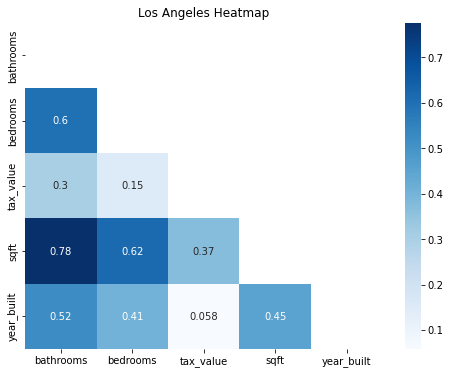

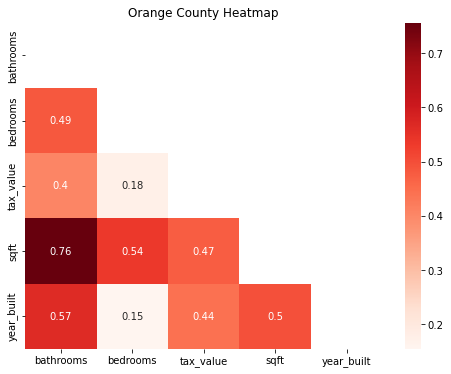

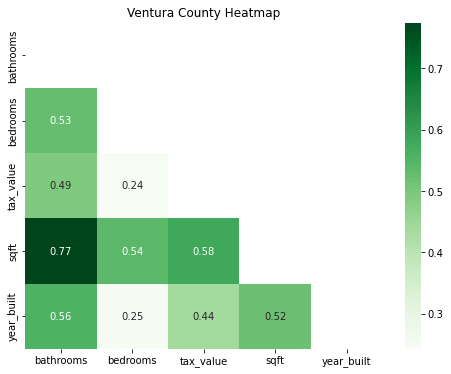

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(la_corr, cmap='Blues', annot=True, mask=np.triu(train_corr))
plt.title('Los Angeles Heatmap')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(orangecounty_corr, cmap='Reds', annot=True, mask=np.triu(train_corr))
plt.title('Orange County Heatmap')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(ventura_corr, cmap='Greens', annot=True, mask=np.triu(train_corr))
plt.title('Ventura County Heatmap')
plt.show()

---

### Question 2 :  Why are some properties valued so differently from others when they are located so close to each other?

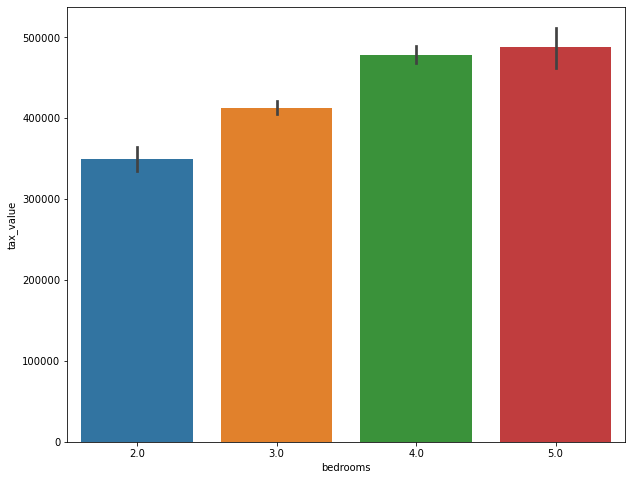

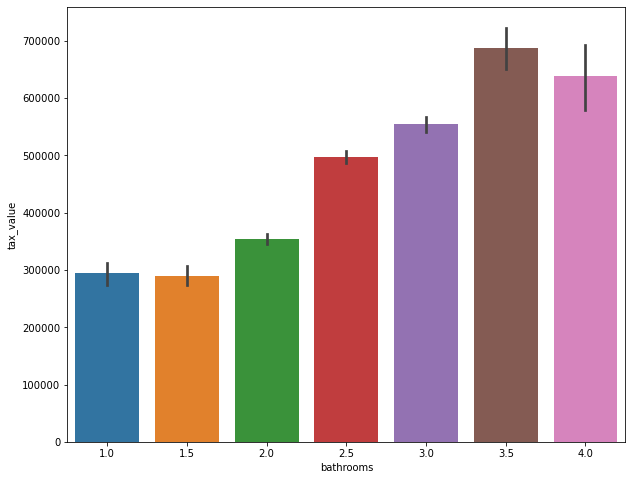

In [35]:
# orangecounty_data = train[train.fips == 'Orange County']
plt.figure(figsize=(10,8))
sns.barplot(data=orangecounty_data, y='tax_value', x='bedrooms')
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(data=orangecounty_data, y='tax_value', x='bathrooms')
plt.show()



### Takeaways:
- Even in speicifc counties where homes are closer to one another, the amount of features in a home generally drives the price up. 

---

### Question 3: Is having 1 Bathroom  worse than have 2 Bathrooms? 

In [36]:
percent = (train[train.bathrooms == 2].count() 
/ len(train))
percent

bathrooms     0.469316
bedrooms      0.469316
tax_value     0.469316
fips          0.469316
sqft          0.469316
year_built    0.469316
dtype: float64

In [37]:
percent = (train[train.bathrooms == 1].count() 
/ len(train))
percent

bathrooms     0.193519
bedrooms      0.193519
tax_value     0.193519
fips          0.193519
sqft          0.193519
year_built    0.193519
dtype: float64

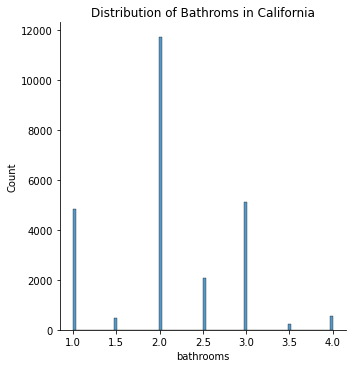

In [38]:
sns.displot(x='bathrooms', data=train)
plt.title('Distribution of Bathroms in California')
plt.show()

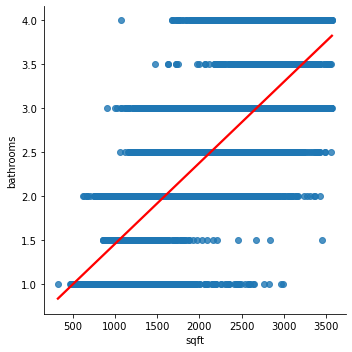

In [39]:
sns.lmplot(x='sqft', y='bathrooms', data=train, size = 5, 
           line_kws={'color':'red'})

### homes withs 2 bathrooms make up  46%

In [40]:
nums = [1, 1.5, 2, 2.5, 3, 3.5, 4]

for num in nums:
    br_value = train[train.bathrooms == num]
    print(f'{num} bathroom(s) average tax value: ',
          "{0:.2f}".format(br_value.tax_value.mean()))
    print('--------------------------------------------------------------------')
    print(' ')

1 bathroom(s) average tax value:  260842.51
--------------------------------------------------------------------
 
1.5 bathroom(s) average tax value:  290341.86
--------------------------------------------------------------------
 
2 bathroom(s) average tax value:  325056.28
--------------------------------------------------------------------
 
2.5 bathroom(s) average tax value:  493553.09
--------------------------------------------------------------------
 
3 bathroom(s) average tax value:  472792.15
--------------------------------------------------------------------
 
3.5 bathroom(s) average tax value:  670967.58
--------------------------------------------------------------------
 
4 bathroom(s) average tax value:  576464.54
--------------------------------------------------------------------
 


In [41]:
nums = [1, 1.5, 2, 2.5, 3, 3.5, 4]

for num in nums:
    br_value = train[train.bathrooms == num]
    print(f'{num} bathroom(s) average tax value: ',
          "{0:.2f}".format(br_value.sqft.mean()))
    print('--------------------------------------------------------------------')
    print(' ')

1 bathroom(s) average tax value:  1077.88
--------------------------------------------------------------------
 
1.5 bathroom(s) average tax value:  1259.12
--------------------------------------------------------------------
 
2 bathroom(s) average tax value:  1546.93
--------------------------------------------------------------------
 
2.5 bathroom(s) average tax value:  2063.08
--------------------------------------------------------------------
 
3 bathroom(s) average tax value:  2344.39
--------------------------------------------------------------------
 
3.5 bathroom(s) average tax value:  2855.44
--------------------------------------------------------------------
 
4 bathroom(s) average tax value:  2855.80
--------------------------------------------------------------------
 


- ${H_0}$ : My null hypothesis is that there is no linear correlation between square feet and number of bathrooms and that they are independent. 
- ${H_a}$ : My alternative hypothesis is that there is a linear correlation.

In [42]:
# set the alpha
alpha = 0.05


t, p = stats.ttest_ind(train.sqft, train.bathrooms, equal_var=False)

if p /2 > alpha:
    print('I fail to rejext the null hypothesis.')
elif t < 0:
    print('I fail to reject the null hypothesis')
else:
    print('I reject the null hypothesis')

I reject the null hypothesis


### Takeaways : 
- Having 1 bathroom isn't worse in terms of payment, however, you're getting a significant decrease in square feet by not having 2 bathrooms.
-  60K increasing from 1 to 2 bathrooms in total value

---

### Question 4: Is there a relationship between the year a home was built and it's value? 

- ${H_0}$ : My null hypothesis is that there is no linear correlation between year built and tax value and that they are independent. 
- ${H_a}$ : My alternative hypothesis is that there is a linear correlation.

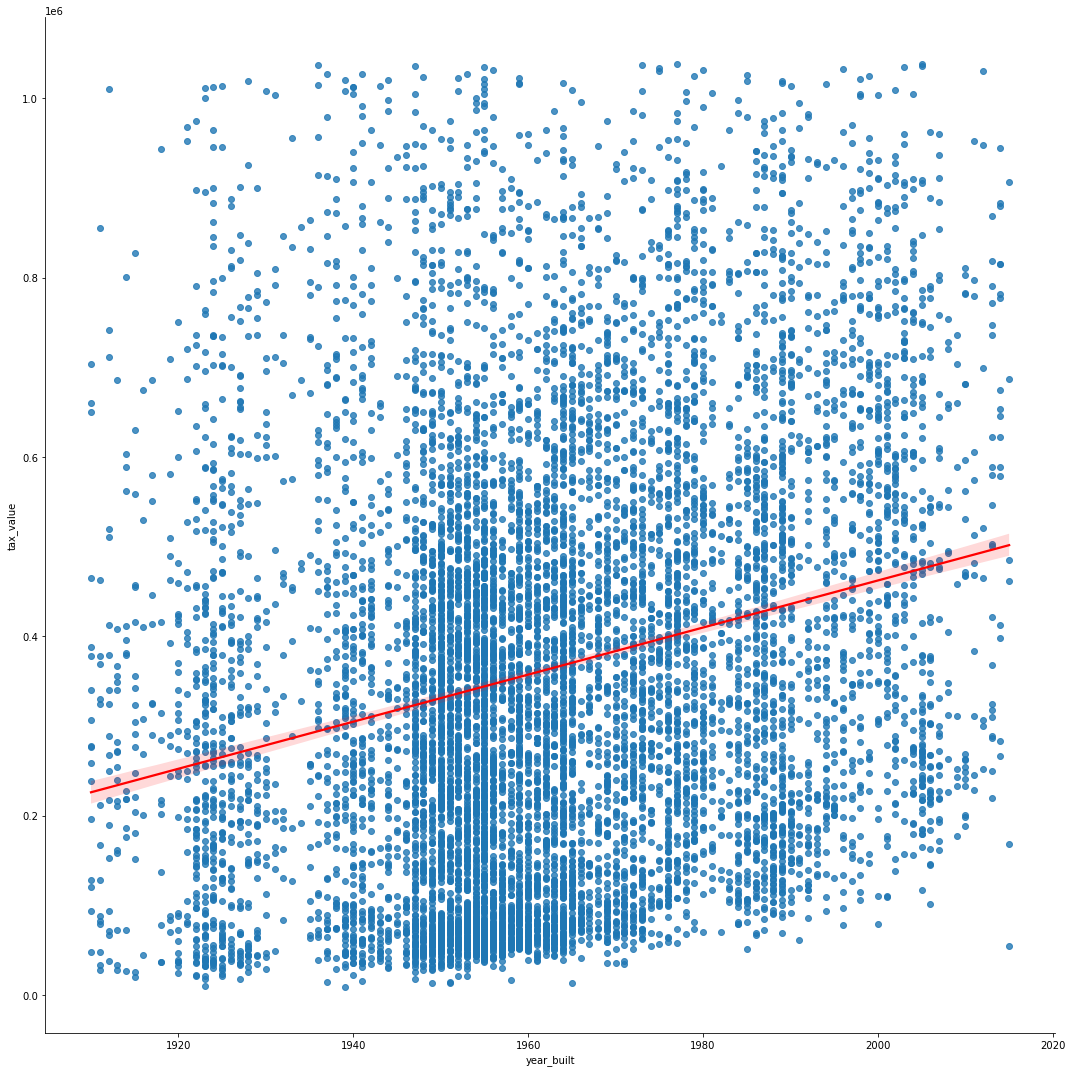

In [43]:
sns.lmplot(x='year_built', y='tax_value', data=train.sample(10_000), size = 15, 
           line_kws={'color':'red'})

### Hypothesis Testing : 

In [44]:
# check for equal variance
print(train.year_built.var())
print(train.tax_value.var())

442.4965935500171
55016987085.52619


In [45]:
# set the alpha
alpha = 0.05


t, p = stats.ttest_ind(train.tax_value, train.year_built, equal_var=False)

if p /2 > alpha:
    print('I fail to rejext the null hypothesis.')
elif t < 0:
    print('I fail to reject the null hypothesis')
else:
    print('I reject the null hypothesis')

I reject the null hypothesis


### Takeaways :
- There is a linear relationship between the year built and the price of the home.
- While majority of homes were built in the 1950s, the newer the home, the higher the tax value.

## Modeling

In [46]:
# evaluate columns
train.columns

Index(['bathrooms', 'bedrooms', 'tax_value', 'fips', 'sqft', 'year_built'], dtype='object')

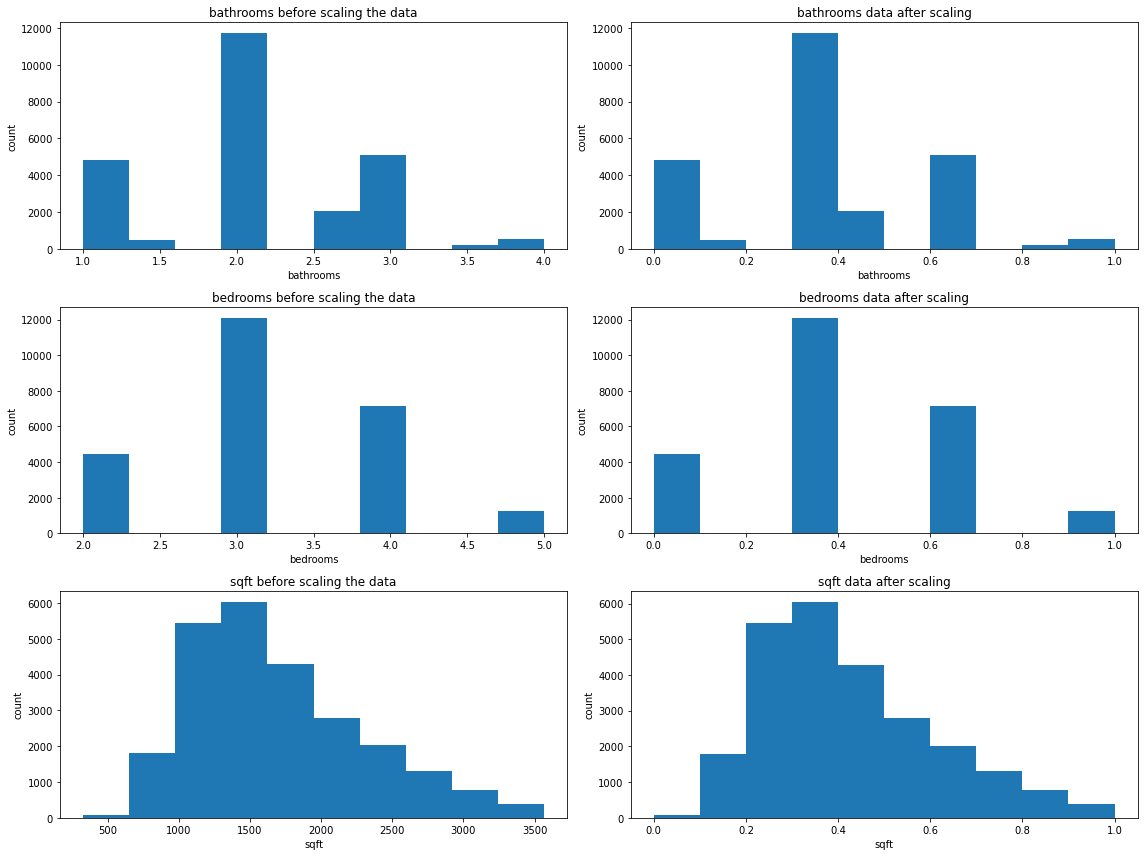

(<Figure size 1152x864 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bathrooms before scaling the data'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms data after scaling'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bedrooms before scaling the data'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms data after scaling'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'sqft before scaling the data'}, xlabel='sqft', ylabel='count'>,
         <AxesSubplot:title={'center':'sqft data after scaling'}, xlabel='sqft', ylabel='count'>]],
       dtype=object))

In [47]:
# Visualization before scaling
def visualize_scaler(scaler, df, target):
    fig, axs = plt.subplots(len(target), 2, figsize=(16,12))
    df_scaled = df.copy()
    df_scaled[target] = scaler.fit_transform(df[target])
    
    for (ax1, ax2), col in zip(axs, target):
        ax1.hist(df[col])
        ax1.set(title=f'{col} before scaling the data', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col])
        ax2.set(title=f'{col} data after scaling', xlabel=col, ylabel='count')
    plt.tight_layout()
    plt.show()
    return fig, axs

visualize_scaler(scaler=MinMaxScaler(), df=train, target = ['bathrooms', 'bedrooms', 'sqft'])

### Takeaways:
- Columns look evenly distributed, so I will go with using hte MinMaxScaler. 
- Moving forward I should scale the data. 

--- 

In [48]:
# create function to return scaled values
def scale_data(train, validate, test, return_scaler=False):
    """
    Scales split data
    
    If scaler = True, scaler object will be returned. Set to False. 
    """
    
    # scale the data
    scaled_cols = ['bedrooms', 'bathrooms', 'sqft']

    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()

    scaler = MinMaxScaler()
    scaler.fit(train[scaled_cols])
    
    # now to transform

    train_scaled[scaled_cols] = scaler.transform(train[scaled_cols])
    validate_scaled[scaled_cols] = scaler.transform(validate[scaled_cols])
    test_scaled[scaled_cols] = scaler.transform(test[scaled_cols])
    
    if return_scaler:
        return train_scaled, validate_scaled, test_scaled, scaler
    else:
        return train_scaled, validate_scaled, test_scaled
    

In [49]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

### Create X and Y groups for modeling

In [50]:
# create X and Y groups for modeling
X_train, y_train = train_scaled.drop(columns=['tax_value', 'fips', 'year_built']), train_scaled.tax_value
X_validate, y_validate = validate_scaled.drop(columns=['tax_value', 'fips','year_built']), validate_scaled.tax_value
X_test, y_test = test_scaled.drop(columns=['tax_value', 'fips','year_built']), test_scaled.tax_value

In [51]:
X_train, y_train = train_scaled.drop(columns=['tax_value', 'fips',
                                              'year_built']), train_scaled.tax_value

In [52]:
X_validate, y_validate = validate_scaled.drop(columns=['tax_value',
                                                       'fips',
                                                       'year_built']), validate_scaled.tax_value

In [53]:
X_validate

,bathrooms,bedrooms,sqft
19800,0.333333,0.333333,0.267593
21827,0.333333,0.333333,0.470679
32674,0.666667,0.333333,0.429938
15846,0.333333,0.333333,0.357099
48676,0.333333,0.333333,0.253704
...,...,...,...
34394,0.666667,0.333333,0.382716
257,0.333333,0.333333,0.356790
349,0.333333,0.666667,0.355247
21600,0.000000,0.000000,0.216049


## Create and Calculate the baseline :

In [54]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

pred_train = y_train.copy()
pred_train = pred_train.rename(columns = {'tax_value': 'actual_value'})

pred_validate = y_validate.copy()
pred_validate = pred_validate.rename(columns = {'tax_value': 'actual_value'})

pred_test = y_test.copy()
pred_test = pred_test.rename(columns = {'tax_value': 'actual_value'})

In [55]:
# calculate baseline mean and baseline predictions
pred_train['baseline_mean'] = y_train.tax_value.mean()
pred_validate['baseline_mean'] = y_train.tax_value.mean()
pred_test['baseline_mean'] = y_test.tax_value.mean()

# calculate baseline median
pred_train['baseline_median'] = y_train.tax_value.median()
pred_validate['baseline_median'] = y_train.tax_value.median()
pred_test['baseline_median'] = y_test.tax_value.median()

### Calculate RMSE using the mean and median as the baseline:

In [56]:
# RMSE of baseline mean
rmse_train = mean_squared_error(pred_train.actual_value,
                                pred_train.baseline_mean)**(1/2)

rmse_validate = mean_squared_error(pred_validate.actual_value,
                                   pred_validate.baseline_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

print(' ')
print('----------------------------------------------------------')
print(' ')

# RMSE of baseline median
rmse_train = mean_squared_error(pred_train.actual_value,
                                pred_train.baseline_median)**(1/2)

rmse_validate = mean_squared_error(pred_validate.actual_value,
                                   pred_validate.baseline_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  234552.3 
Validate/Out-of-Sample:  233189.25
 
----------------------------------------------------------
 
RMSE using Median
Train/In-Sample:  236904.68 
Validate/Out-of-Sample:  235981.09


### The mean baseline has a lower RMSE so I will use it as the baseline to evaluate the models against.

## Linear Regression Model (OLS) :
- RMSE #1

In [57]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train)

pred_train['ols'] = lm.predict(X_train)
pred_validate['ols'] = lm.predict(X_validate)


rmse_train1 = mean_squared_error(pred_train.actual_value,
                                pred_train.ols)**(1/2)

rmse_validate1 = mean_squared_error(pred_validate.actual_value,
                                pred_validate.ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train1, 
      "\nValidation/Out-of-Sample: ", rmse_validate1)

RMSE for OLS using LinearRegression
Training/In-Sample:  209299.02807571486 
Validation/Out-of-Sample:  211566.669191326


In [58]:
lm.score(X_train, y_train)

0.20373978448096886

## TweedieRegressor
- RMSE #2

In [59]:
# create the model object
glm = TweedieRegressor(power=1, alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train)

# predict train
pred_train['glm'] = glm.predict(X_train)
pred_validate['glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_train2 = mean_squared_error(pred_train.actual_value, pred_train.glm)**(1/2)

# evaluate: rmse
rmse_validate2 = mean_squared_error(pred_validate.actual_value, pred_validate.glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=4\nTraining/In-Sample: ", rmse_train2, 
      "\nValidation/Out-of-Sample: ", rmse_validate2)

RMSE for GLM using Tweedie, power=1 & alpha=4
Training/In-Sample:  209663.51673456634 
Validation/Out-of-Sample:  212082.9282108506


## Polynomial Regression
- RMSE #3

In [60]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [61]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train)

# predict train
pred_train['lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train3 = mean_squared_error(pred_train.actual_value, pred_train.lm2)**(1/2)

# predict validate
pred_validate['lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate3 = mean_squared_error(pred_validate.actual_value, pred_validate.lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train3, 
      "\nValidation/Out-of-Sample: ", rmse_validate3)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  209208.52149839845 
Validation/Out-of-Sample:  211553.83191534973


### LassorLars
- RMSE #4

In [62]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train)

# predict 
pred_train['lars'] = lars.predict(X_train)
pred_validate['lars'] = lars.predict(X_validate)


# evaluate: rmse
rmse_train4 = mean_squared_error(pred_train.actual_value, pred_train.lars)**(1/2)

# evaluate: rmse
rmse_validate4 = mean_squared_error(pred_validate.actual_value, pred_validate.lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train4, 
      "\nValidation/Out-of-Sample: ", rmse_validate4)


RMSE for Lasso + Lars
Training/In-Sample:  209299.36664573182 
Validation/Out-of-Sample:  211554.4393087699


### Choosing the best model : 

In [63]:
print("RMSE for OLS\nTraining/In-Sample: ", rmse_train1, 
      "\nValidation/Out-of-Sample: ", rmse_validate1)

print(' ')

print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", rmse_train2, 
      "\nValidation/Out-of-Sample: ", rmse_validate2)

print(' ')

print("RMSE for Polynomial Regression\nTraining/In-Sample: ", rmse_train3, 
      "\nValidation/Out-of-Sample: ", rmse_validate3)

print(' ')

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train4, 
      "\nValidation/Out-of-Sample: ", rmse_validate4)

print(' ')

RMSE for OLS
Training/In-Sample:  209299.02807571486 
Validation/Out-of-Sample:  211566.669191326
 
RMSE for Tweedie Regressor
Training/In-Sample:  209663.51673456634 
Validation/Out-of-Sample:  212082.9282108506
 
RMSE for Polynomial Regression
Training/In-Sample:  209208.52149839845 
Validation/Out-of-Sample:  211553.83191534973
 
RMSE for Lasso + Lars
Training/In-Sample:  209299.36664573182 
Validation/Out-of-Sample:  211554.4393087699
 


### Polynomial Regression Model has the lowest RMSE for both in-sample and out-of-sample data. This will be the MVP model.

#### Evaluate the Model on Test

In [64]:
# predict on test
pred_test['lms'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(pred_test.actual_value, pred_test.lms)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Regression using LinearRegression
Out-of-Sample Performance:  207697.06752286284


### Plotting Actual vs Predicted

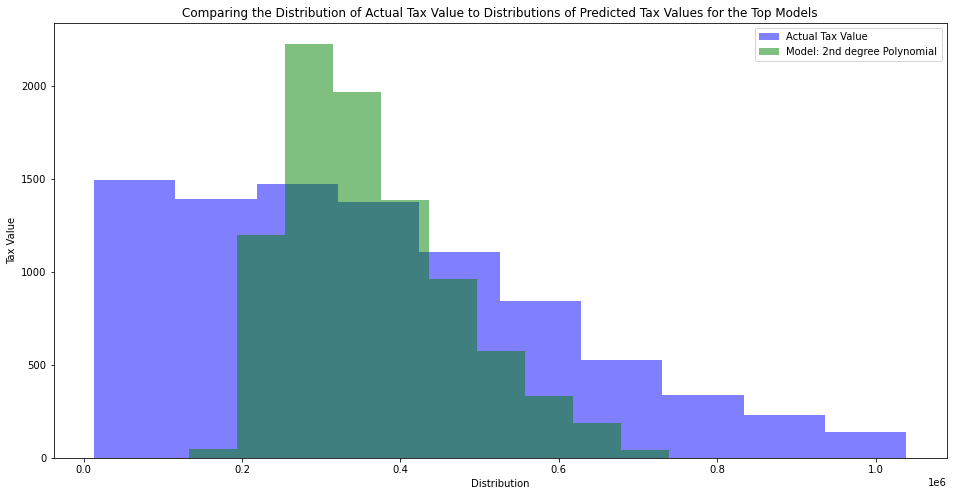

In [65]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(pred_test.actual_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(pred_test.lms, color='green', alpha=.5, label="Model: 2nd degree Polynomial")
plt.xlabel("Distribution")
plt.ylabel("Tax Value")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()
